# Motion Code

This notebook presents a variational inference approach using sparse Gaussian processes for time series forecasting and motion recognition. By extracting distinctive vectors from motion trajectories, our method groups similar patterns and infers relationships between different motions. It streamlines the prediction and classification of time series across various motion types by optimizing the ELBO on the compiled motion data.

## Prior work on Sparse Gaussian process
### Exact Gaussian processes
Consider a Gaussian process $ f(x) $ for $ x \in \mathbb{R}^d $. The joint distribution of a finite collection of points follows a multivariate Gaussian:
\begin{equation}
p(\mathbf{f}) = \mathcal{N}(\mathbf{f}| \boldsymbol{\mu}, \mathbf{K}),
\end{equation}
where $ \mathbf{f} = [f(x_1), \ldots, f(x_n)]^T $, $ \boldsymbol{\mu} $ is the mean vector, and $ \mathbf{K} $ is the covariance matrix, determined by evaluating the kernel function at the input points contained in $ X $.

Predictive distributions for new data points $ X_* $ are obtained by:
\begin{align}
p(f_*|X_*, X, y) &= \mathcal{N}(f_*|\mu_*, \Sigma_*),\\
\mu_* &= \mathbf{K}_*^T \mathbf{K}_y^{-1} y,\\
\Sigma_* &= \mathbf{K}_{**} - \mathbf{K}_*^T \mathbf{K}_y^{-1} \mathbf{K}_*,
\end{align}
where $ \mathbf{K}_* $ is the covariance matrix between $ X_* $ and $ X $, $ \mathbf{K}_{**} $ is the covariance matrix of $ X_* $, and $ \mathbf{K}_y = \mathbf{K} + \sigma^2_n I $ is the covariance matrix of the observed outputs $ y $ with noise variance $ \sigma^2_n $.

### Sparse Gaussian Processes

In Sparse Gaussian Processes, we address the computational complexity inherent in exact Gaussian Processes by introducing inducing points, $ X_m $, which act as a representative subset of the full dataset. These inducing points enable us to approximate the full covariance matrix with a lower-rank representation. The seminal work by Titsias centers on identifying an optimal set of inducing points to effectively summarize the characteristics of the underlying stochastic process.

To facilitate computations with only the inducing points, we express the marginal log-likelihood by marginalizing over the latent function values $ f $ and the inducing variables $ f_m $:

$$
\log p(y) = \log \int p(y|f)p(f|f_m)p(f_m)dfdf_m
$$

The exact posterior distribution $ p(f, f_m) = p(f|f_m)p(f_m) $ is computationally intractable due to its dependence on all $ f $. Hence, we approximate it with a variational distribution $ q(f_m) $ that approximates the intractable true posterior $ p(f_m | y) $, thereby maximizing the evidence lower bound (ELBO) $ \mathcal{L} $:

$$
\log p(y) \geq \int q(f_m) \log \frac{p(y|f_m)p(f_m)}{q(f_m)} df_m = \mathcal{L}
$$

After optimizing $ q(f_m) $, the ELBO simplifies to:

$$
\mathcal{L}(X_m) = \log \mathcal{N}(y|0, \sigma_n^2I + Q_{nn}) - \frac{1}{2\sigma_n^2} \text{Tr}(K_{nn} - Q_{nn})
$$

where $ Q_{nn} $ is the part of the covariance that is approximated using the inducing points, defined as:

$$
Q_{nn} = K_{nm}K_{mm}^{-1}K_{mn}
$$

with $ K_{nm} $ as the covariance between the training inputs and the inducing points, $ K_{mm} $ as the covariance matrix evaluated at the inducing points, and $ K_{mn} $ as $ K_{nm}^T $. The matrix $ K_{nn} $ is the covariance matrix evaluated at all training inputs, and $ \sigma_n^2I $ denotes the noise term in the observations. Optimizing $ \mathcal{L}(X_m) $ involves selecting the inducing points $ X_m $ and kernel hyperparameters to achieve an optimal trade-off between the fidelity of the model to the data and its complexity.


### Multi-output Gaussian Process

Leveraging Cramér's representation theorem, which provides a foundation for the covariance functions of multivariate stochastic processes, Parra and Tobar developed spectral mixture kernels for multi-output Gaussian processes (MOGP). These kernels are expressed as:

\begin{align}
k_{ij}(\tau) &= \sum_{q=1}^Q \alpha_{ij}^{(q)}\exp\left(-\frac{1}{2}(\tau+\theta_{ij}^{(q)})^T\Sigma_{ij}^{(q)}(\tau+\theta_{ij}^{(q)})\right) \nonumber \\
&\quad \times \cos\left((\tau + \theta_{ij}^{(q)})^T\mu_{ij}^{(q)} + \phi_{ij}^{(q)}\right),
\end{align}

where $ \tau $ is the time lag or the difference between input locations, $ \alpha_{ij}^{(q)} = w_{ij}^{(q)}(2\pi)^{C/2}|\Sigma_{ij}^{(q)}|^{1/2} $, and $ C $ is the number of channels (dimensions of the $ y $-output).

The parameters $ w_{ij}, \theta_{ij}, \Sigma_{ij}, \mu_{ij} $, and $ \phi_{ij} $ are related to their single-output counterparts as follows:

- Covariance: $ \Sigma_{ij} = 2\Sigma_i(\Sigma_i + \Sigma_j)^{-1}\Sigma_j $.
- Mean: $ \mu_{ij} = (\Sigma_i + \Sigma_j)^{-1}(\Sigma_i\mu_j + \Sigma_j\mu_i) $.
- Magnitude: 
    $$
    w_{ij} = w_iw_j \times \exp\left(-\frac{1}{4}(\mu_i-\mu_j)^T(\Sigma_i+\Sigma_j)^{-1}(\mu_i-\mu_j)\right),
    $$
- Delay: $ \theta_{ij} = \theta_i-\theta_j $.
- Phase: $ \phi_{ij} = \phi_i - \phi_j $.

Given $ N $ observations $ D = \{(x_c, i_c, y_c)\}_{c=1}^N $ for location $ x_c \in \mathcal{X} $, target $ y_c $, and channel $ i_c \in \{1, \ldots, C\} $, an MOGP with $ C $ channels can be learned by optimizing the negative log-likelihood:

\begin{equation}
 -\log p(\mathbf{y}|\mathbf{x}, \Theta) = \frac{N}{2}\log(2\pi) + \frac{1}{2}\log|\mathbf{K}_{\xi}| + \frac{1}{2}\mathbf{y}^T\mathbf{K}_{\xi}^{-1}\mathbf{y},
\end{equation}

where $ \mathbf{y} $ and $ \mathbf{x} $ represent the stacked target and location observations respectively, and $ \Theta $ includes all kernel parameters as well as the target noise variance $ \sigma_{i, \text{noise}}^2 $ for each channel $ i $. The covariance matrix $ \mathbf{K}_{\xi} $ is constructed using the spectral mixture kernels:

\begin{equation}
[\mathbf{K}_{\xi}]_{rs} = k_{i_ri_s}(x_r - x_s) + \sigma^2_{i_r, \text{noise}}\delta_{i_ri_s},
\end{equation}

with $ \delta_{i_ri_s} $ being the Kronecker delta function. By considering the extended space $ \mathcal{X} \times \{1, \ldots, C\} $, the MOGP framework can be equivalently represented as a higher-dimensional, real-valued Gaussian Process. The set of all kernel parameters is denoted by $ \eta $, where $ \eta = \{(w_i^{(q)}, \theta_i^{(q)}, \Sigma_i^{(q)}, \mu_i^{(q)}, \phi_i^{(q)}) \mid i=1,\ldots,C \text{ and } q=1,\ldots,Q\} $.


## Learning over multiple collection of time series with motion code
Suppose we are given a collection of $L$ motions, each characterized by a single stochastic process, and has a collection of corresponding time series sample data. Given any time series input data, our main task is to classify/recognize this time series (which motion type it has), and at the same time forecast values at future times. In this section, we introduce a novel technique called **motion code learning** to handle this problem. In the next section, we show a few results in applying our technique to the above task.

### Multiple collection of time series samples
**The section you've provided discusses a method for maximizing the joint posterior likelihood of multiple (independent) time series by using a variational inference approach, specifically by optimizing the Evidence Lower Bound (ELBO). The goal of this approach is to approximate the true posterior distribution over the latent functions that generate the time series data with a more tractable distribution.**


Assume that we need to maximize the joint posterior likelihood of $B$ (independent) timeseries $\set{y_j}_{j=1}^B$. To do so we consider the ELBO loss for the average of $\log p(y_j)$:
\begin{align}
\mathcal{L} &= \sum_{j=1}^B \frac{1}{B} \int \phi(f_m) \log \frac{\mathcal{N}(y_j|\alpha_j, \sigma^2I)p(f_m)}{\phi(f_m)} df_m \nonumber \\
&-\frac{1}{2\sigma^2} Tr(K^j_{nn}-Q^j_{nn}) \nonumber \\
&= \int \phi(f_m) \log\Bigg(\prod_j \mathcal{N}(y_j|\alpha_j, \sigma^2I)\Bigg)^{1/B} \frac{p(f_m)}{\Phi(f_m)} df_m \nonumber \\
&- \frac{1}{2\sigma^2}\sum_j Tr(K^j_{nn}-Q^j_{nn})
\end{align}
where $\alpha_j = E[f_j|f_m]$ where $f_j = (f(X^j_i))$ with $X$-data $(X^j_i)_i$ for $j$th timeseries. The first term is upper bounded by:
\begin{align}
\mathcal{L}_1 &= \log \int \Bigg(\prod_j \mathcal{N}(y_j|\alpha_j, \sigma^2I)\Bigg)^{1/B} p(f_m) df_m \nonumber \\
&= \log \int\mathcal{N}(Y|\mathrm{A}, B\sigma^2)p(f_m) df_m \nonumber\\
&= \log \mathcal{N}\Bigg(Y\Bigg|0, B\sigma^2 I + 
    \begin{bmatrix}
        Q^1_{nn} & 0 & 0\\
        0 & \ddots & 0\\
        0 & 0 & Q^B_{nn}
    \end{bmatrix} \Bigg)
\end{align}
where $Y = \begin{bmatrix} y_1 \\ \vdots \\ y_B \end{bmatrix}$, and $\mathrm{A} = \begin{bmatrix} \alpha_1 \\ \vdots \\ \alpha_B \end{bmatrix}$.

The equality holds when:
\begin{align}
\phi(f_m) &\sim \prod_{j=1}^B \mathcal{N}(y_j|\alpha_j, \sigma^2I)^{1/B}p(f_m) \nonumber \\
&= c \exp\Bigg( \frac{\sigma^{-2}}{B} \sum_{j=1}^B  y_j^T K_{n_jm} K_{mm}^{-1}f_m - \frac{1}{2} f_m^T \nonumber \\
&(K_{mm}^{-1} + \frac{\sigma^{-2}}{B}\sum_{j=1}^B K_{mm}^{-1}K_{mn_j}K_{n_jm}K_{mm}^{-1})f_m \Bigg) \nonumber\\
&= \mathcal{N}\Bigg(f_m\Bigg|\sigma^{-2}K_{mm}\Lambda\left(\frac{1}{B}\sum_{j=1}^B K_{mn_j}y_j\right), \nonumber \\ 
& \quad \quad \quad K_{mm}\Lambda K_{mm} \Bigg)
\end{align}
where $\Lambda^{-1}=\Sigma = K_{mm} + \frac{\sigma^{-2}}{B}\sum_{j=1}^B K_{mn_j}K_{n_jm}$.

Given new data, the prediction is still the same as sparse Gaussian process for one time series. For inducing point distribution $\Phi(f_m) = \mathcal{N}(f_m|\mu_m, A_m)$, then the predicted distribution is:
\begin{align}
\mathcal{N}(f_*|&K_{*m}K_{mm}^{-1}\mu_m, K_{**}-K_{*m}K_{mm}^{-1}K_{m*} \nonumber\\
& + K_{*m}K_{mm}^{-1}A_mK_{mm}^{-1}K_{m*})
\end{align}

### Simple classification approach
Assume that we follow a simple approach and learn each individual type of motions separately. Suppose that after the learning step for each type of motion $k$ with $k \in \overline{1, L}$, we obtain optimal inducing points $X_m^k$ and corresponding kernel $K_{\theta_k}$ with optimal $\theta_k \in \mathbb{R}^2$. Then using classification, in prediction phase, the incoming motion data should have the optimal inducing points and kernel of the form:
\begin{align}
X_m &= \sum_{k=1}^L \alpha_k X_m^k \\
K(x, x') &= \sum_{k=1}^L \alpha_k K_{\theta_k}(x, x')
\end{align}
where $\alpha = [\alpha_1, \cdots, \alpha_L]$ is the probability distribution over different types of possible motion for the incoming data. Thus, we only need to optimize $\alpha$ so that the ELBO loss $\mathcal{L}(X_m) = \mathcal{L}(\alpha)$ is optimized. This simple approach motivate use to consider general $X_m$ that can be a linear combination of less than $L$ optimal matrices of inducing points.


### Motion Code Learning
Recall that each time series is modeled by a stochastic process called a **motion**, and the time series data is a realization of this process. For each type of motion, we associate it with a motion (latent) code, which is a vector $ z \in \mathbb{R}^d $. Assume that there are $ L $ types of motions (stochastic processes), and for motion $ k $ for $ k \in \{1, \ldots, L\} $, we get a set of training trajectories data with the (time) variable $ X_k $ and target $ y_k $. One of our goals is to find the "optimal" motion codes $ z_1, z_2, \ldots, z_L $ corresponding to $ L $ types of motion.

We fix a number $ m $, a number small enough to be the number of inducing points for one motion. We introduce the block-inducing point $ X_m $ with dimension $ m \times d $, so that for each motion with code $ z $, its inducing points are approximately the vector $ X_m z $. Each motion $ j $ will also have a set of kernel parameters $ \eta_k $ for $ k \in \{1, \ldots, L\} $.

We want to optimize the motion codes $ z_1, z_2, \ldots, z_L $, block-inducing points $ X_m $, and individual kernel sets of parameters $ \eta_1, \eta_2, \ldots, \eta_L $ so that the posterior log-likelihood is maximized:
\begin{align}
\log p(X_1, X_2, \ldots, X_L) &\sim \sum_{k=1}^L \log p(X_k \mid z_k, \eta_k) + \sum_{k=1}^L p(z_k) \\
&\geq \sum_{k=1}^L \mathcal{L}(X_m, \eta_k) + \lambda \sum_{k=1}^L \| z_k \|^2 \\
&= \sum_{k=1}^L \mathcal{L}(X_m z_k, \eta_k) + \lambda \sum_{k=1}^L \| z_k \|^2
\end{align}
Here we assume a Gaussian distribution with mean $ 0 $ for the latent codes $ z $. After optimizing $ X_m $, and kernel parameters $ \{\eta_k\} $ for $ L $ motions, to predict the motion code $ z $ for any incoming data $ (X, y) $, we also maximize the posterior log-likelihood:
\begin{equation}
\log p(X) \sim \mathcal{L}(X_m z; \eta_1, \ldots, \eta_L) + \lambda \| z \|^2 = \mathcal{L}_1(z)
\end{equation}
The predicted motion code $ z $ for the new incoming data helps us perform classification, while the predicted variable $ X_m z $ helps us perform forecasting on future (time) variables.


### Sample efficiency
Instead of using all of the data $\set{X_k}_{k=1}^L$, we perform a greedy algorithm and add a small subset of sample data at each time for optimizing $X_m, z_k$ and $\eta_k$. We can stop after finding no significant change to optimized variables $X_m, z_k, \eta_k$. Due to the nature of the inducing points $X_m$, which capture most of the uncertainty across different stochastic process, many subsequent sample data batches will be unnecessary. Thus, this greedy algorithm can utilize the training data more efficiently.

In the proposed section on inference, we aim to describe the process of using a trained model to predict new data points. Here, the model has learned motion codes and kernel parameters for different types of motions. During inference, these learned parameters are used to map new data into the motion space and make predictions.

### Inference with Motion Code Learning

After the training phase, we have the motion codes $ z_1, z_2, \ldots, z_L $, the block-inducing points $ X_m $, and kernel parameters $ \eta_1, \eta_2, \ldots, \eta_L $. When new motion data is received, the task is to infer the type of motion and forecast future values. This is done by finding the motion code $ z $ that best explains the new data given the learned parameters.

#### Input and Mapping

The input to the inference process is a new set of motion data characterized by feature observations $ X $ and possibly target values $ y $ if forecasting is also desired. This data is then mapped through the learned block-inducing points $ X_m $ with the following transformation:

$$
X_m' = X_m z
$$

Here, $ z $ is an unknown motion code for the new data, which we aim to determine. This code captures the latent characteristics of the motion corresponding to the new data and acts as a compact representation.

#### Learned Parameters and Their Utilization

The learned parameters $ X_m $, $ \{z_k\} $, and $ \{\eta_k\} $ from the training phase are utilized during inference in the following manner:

- The block-inducing points $ X_m $ provide a basis for mapping the latent motion code $ z $ to the inducing point space.
- The motion codes $ \{z_k\} $ for each motion type serve as reference points for classification.
- The kernel parameters $ \{\eta_k\} $ dictate the behavior of the covariance function for each motion type.

In the context of Gaussian processes, the kernel function $ K $ shaped by $ \{\eta_k\} $ controls how points in the input space are related in terms of their output values. It is critical for both forecasting future values and determining similarity between the new data and each type of motion.

#### Optimization and Output

To infer $ z $, we maximize the following posterior log-likelihood with respect to $ z $:

$$
\log p(X) \approx \mathcal{L}(X_m z; \eta_1, \ldots, \eta_L) + \lambda \| z \|^2 = \mathcal{L}_1(z)
$$

Here, $ \mathcal{L}_1(z) $ is the Evidence Lower Bound (ELBO) adapted for our specific inference case. By optimizing $ \mathcal{L}_1(z) $, we find the most probable motion code $ z $ for the new data.

The output of the inference step consists of two parts:

1. **Classification**: The motion code $ z $ infers the type of motion from the predefined set $ \{z_1, z_2, \ldots, z_L\} $, thereby classifying the new data.
   
2. **Forecasting**: By utilizing the inducing points $ X_m' = X_m z $, we forecast future values for the time series. This involves computing the predictive distribution for new time points, leveraging the structure of sparse Gaussian processes.

#### Summary

In summary, during inference, the trained motion code learning model takes in new motion data, utilizes the learned inducing points, motion codes, and kernel parameters to infer a latent motion code, and outputs both a classification of the motion and forecasts future values. The process is computationally efficient due to the reduced dimensionality introduced by the motion codes and block-inducing points, while the Gaussian process framework allows for uncertainty quantification in the predictions.

## Summary of What We're Trying to Do

### Problem
Suppose we are given a collection of $L$ motions, each characterized by a single stochastic process, and has a collection of corresponding time series sample data. Given any time series input data, our main task is to classify/recognize this time series (which motion type it has), and at the same time forecast values at future times. We do this with a novel technique called **motion code learning** to handle this problem. 

### Inference
Suppose we already have a trained model. What does inference look like?

We have some observation data $(X, y)$ and we want to predict the class $k$ that it belongs to, and also predict the future values $y_{new}$ for some future time $X_{new}$.

The input to our model is $(X,y)$, and this gets mapped to some latent space $z \in \mathbb{R}^d$ which we cal the latent motion code. $z$ captures relevant information of the pair $(X,y)$. Our next step is to map this to inducing points via the map $X_m z \in \mathbb{R}^m$. I'm not sure what these undicing points represent. 

Questions:
- What are the undicing points?
- How do we figure out the class?

### Learning

# Chinatown Dataset Overview

The Chinatown dataset is a univariate time series classification dataset provided by the UCR/UEA time series classification archive. The dataset is particularly interesting as it represents a real-world application of time series data for predicting pedestrian traffic in urban environments.

## Context and Data Collection

The data originates from the pedestrian counts in the Chinatown area of Melbourne. These counts were recorded every 10 minutes and are indicative of the foot traffic within the region. Understanding such patterns is critical for city planning, businesses operating in the area, and managing pedestrian flows during events or peak times.

## Dataset Composition

The Chinatown dataset is composed of time series data where each instance represents the pedestrian count over a period. Specifically, the dataset comprises:

- **363 instances:** Each instance is a time series.
- **1 dimension:** The dataset is univariate, meaning there is a single time series per instance representing pedestrian count.
- **24 time points:** Each time series has 24 time points, with counts recorded every 10 minutes over a 4-hour period.

Each time series is labeled with a class that can represent different days or events affecting pedestrian traffic.

## Objective

The main objective when working with the Chinatown dataset is to build a time series classification model. Such a model will learn to predict the label of a time series based on the observed pedestrian counts. In practical terms, this could be used to predict the type of day or event based on foot traffic patterns.

## Exploratory Analysis and Visualization

Exploratory data analysis for this dataset involves visualizing the time series to understand the underlying patterns and variances. Visualizations typically include line plots of the time series, which can help in identifying common patterns or anomalies in pedestrian counts associated with different labels.

## Applications

The insights gained from analyzing the Chinatown dataset have broader applications in urban analytics. For instance:

- **Event Planning:** By predicting pedestrian traffic, organizers can better plan for events by understanding expected foot traffic and its impacts.
- **Business Strategy:** Retailers and service providers can tailor their operations, such as staffing and stock levels, according to predicted footfall.
- **Urban Design:** City planners can use traffic patterns to design better pedestrian pathways or to identify times for maintenance work with minimal disruption.

In conclusion, the Chinatown dataset serves as a valuable resource for developing and benchmarking time series classification models with practical implications for urban planning and business strategies.



Suppose we are given a collection of $L$ motions, each characterized by a single stochastic process, and has a collection of corresponding time series sample data. Given any time series input data, our main task is to classify/recognize this time series (which motion type it has), and at the same time forecast values at future times. In this section, we introduce a novel technique called \textbf{motion code learning} to handle this problem. In the next section, we show a few results in applying our technique to the above task.

\subsection{Multiple collection of time series samples}
Assume that we need to maximize the joint posterior likelihood of $B$ (independent) timeseries $\set{y_j}_{j=1}^B$. To do so we consider the ELBO loss for the average of $\log p(y_j)$:
\begin{align}
\mathcal{L} &= \sum_{j=1}^B \frac{1}{B} \int \phi(f_m) \log \frac{\mathcal{N}(y_j|\alpha_j, \sigma^2I)p(f_m)}{\phi(f_m)} df_m \nonumber \\
&-\frac{1}{2\sigma^2} Tr(K^j_{nn}-Q^j_{nn}) \nonumber \\
&= \int \phi(f_m) \log\Bigg(\prod_j \mathcal{N}(y_j|\alpha_j, \sigma^2I)\Bigg)^{1/B} \frac{p(f_m)}{\Phi(f_m)} df_m \nonumber \\
&- \frac{1}{2\sigma^2}\sum_j Tr(K^j_{nn}-Q^j_{nn})
\end{align}
where $\alpha_j = E[f_j|f_m]$ where $f_j = (f(X^j_i))$ with $X$-data $(X^j_i)_i$ for $j$th timeseries. The first term is upper bounded by:
\begin{align}
\mathcal{L}_1 &= \log \int \Bigg(\prod_j \mathcal{N}(y_j|\alpha_j, \sigma^2I)\Bigg)^{1/B} p(f_m) df_m \nonumber \\
&= \log \int\mathcal{N}(Y|\mathrm{A}, B\sigma^2)p(f_m) df_m \nonumber\\
&= \log \mathcal{N}\Bigg(Y\Bigg|0, B\sigma^2 I + 
    \begin{bmatrix}
        Q^1_{nn} & 0 & 0\\
        0 & \ddots & 0\\
        0 & 0 & Q^B_{nn}
    \end{bmatrix} \Bigg)
\end{align}
where $Y = \begin{bmatrix} y_1 \\ \vdots \\ y_B \end{bmatrix}$, and $\mathrm{A} = \begin{bmatrix} \alpha_1 \\ \vdots \\ \alpha_B \end{bmatrix}$.

The equality holds when:
\begin{align}
\phi(f_m) &\sim \prod_{j=1}^B \mathcal{N}(y_j|\alpha_j, \sigma^2I)^{1/B}p(f_m) \nonumber \\
&= c \exp\Bigg( \frac{\sigma^{-2}}{B} \sum_{j=1}^B  y_j^T K_{n_jm} K_{mm}^{-1}f_m - \frac{1}{2} f_m^T \nonumber \\
&(K_{mm}^{-1} + \frac{\sigma^{-2}}{B}\sum_{j=1}^B K_{mm}^{-1}K_{mn_j}K_{n_jm}K_{mm}^{-1})f_m \Bigg) \nonumber\\
&= \mathcal{N}\Bigg(f_m\Bigg|\sigma^{-2}K_{mm}\Lambda\left(\frac{1}{B}\sum_{j=1}^B K_{mn_j}y_j\right), \nonumber \\ 
& \quad \quad \quad K_{mm}\Lambda K_{mm} \Bigg)
\end{align}
where $\Lambda^{-1}=\Sigma = K_{mm} + \frac{\sigma^{-2}}{B}\sum_{j=1}^B K_{mn_j}K_{n_jm}$.

Given new data, the prediction is still the same as sparse Gaussian process for one time series. For inducing point distribution $\Phi(f_m) = \mathcal{N}(f_m|\mu_m, A_m)$, then the predicted distribution is:
\begin{align}
\mathcal{N}(f_*|&K_{*m}K_{mm}^{-1}\mu_m, K_{**}-K_{*m}K_{mm}^{-1}K_{m*} \nonumber\\
& + K_{*m}K_{mm}^{-1}A_mK_{mm}^{-1}K_{m*})
\end{align}

\subsection{Simple classification approach}
Assume that we follow a simple approach and learn each individual type of motions separately. Suppose that after the learning step for each type of motion $k$ with $k \in \overline{1, L}$, we obtain optimal inducing points $X_m^k$ and corresponding kernel $K_{\theta_k}$ with optimal $\theta_k \in \mathbb{R}^2$. Then using classification, in prediction phase, the incoming motion data should have the optimal inducing points and kernel of the form:
\begin{align}
X_m &= \sum_{k=1}^L \alpha_k X_m^k \\
K(x, x') &= \sum_{k=1}^L \alpha_k K_{\theta_k}(x, x')
\end{align}
where $\alpha = [\alpha_1, \cdots, \alpha_L]$ is the probability distribution over different types of possible motion for the incoming data. Thus, we only need to optimize $\alpha$ so that the ELBO loss $\mathcal{L}(X_m) = \mathcal{L}(\alpha)$ is optimized. This simple approach motivate use to consider general $X_m$ that can be a linear combination of less than $L$ optimal matrices of inducing points.

\subsection{Motion code learning}
Recall that each time series is modeled by a stochastic process called a \textbf{motion}, and the time series data is a realization of this process. For each type of motion, we associate with it a motion (latent) code, which is a vector $z \in \mathbb{R}^d$. Assume that there are $L$ types of motions (stochastic processes), and for motion $k$ for $k \in \overline{1, L}$, we get a set of training trajectories data with the (time) variable $X_k$ and target $y_k$. One of our goal is to find the "optimal" motion codes $z_1, z_2, \cdots, z_L$ corresponding to $L$ types of motion.

We fix a number $m$, a number small enough to be the number of inducing points for one motion. We introduce the block-inducing point $X_m$ with dimension $m \times d$, so that for each motion with code $z$, its inducing points are approximately the vector $X_m z$. Each motion $j$ will also have a set of kernel parameters $\eta_k$ for $k \in \overline{1, L}$.

We want to optimize the motion code $z_1, z_2, \cdots, z_L$, block-inducing points $X_m$, and individual kernel sets of parameters $\eta_1, \eta_2, \cdots, \eta_L$ so that the posterior log likelihood is maximized:
\begin{align}
\log p(X_1, X_2 \cdots, X_L) &\sim \sum_{k=1}^L \log p(X_k|z_k, \eta_k) + \sum_{k=1}^L p(z_k) \nonumber \\
&\geq \sum_{k=1}^L \mathcal{L}(X_m^k, \eta_k) + \lambda \sum_{k=1}^L\norm{z_k}^2 \nonumber\\
&= \sum_{k=1}^L \mathcal{L}(X_m z_k, \eta_k) + \lambda \sum_{k=1}^L\norm{z_k}^2
\end{align}
Here we assume Gaussian distribution with mean $0$ for the latent code $z$. After optimizing $X_m$, and kernel parameters $\set{\eta_k}$ for $L$ motions, to predict the motion code $z$ for any incoming data $(X, y)$, we also maximize the posterior log-likelihood:
\begin{equation}
\log p(X) \sim \mathcal{L}(X_mz; \eta_1, \cdots, \eta_L) + \lambda \norm{z}^2 = \mathcal{L}_1(z)
\end{equation}
The predicted motion code $z$ for the new incoming data helps us perform classification, while the predicted variable $X_mz$ helps us perform forecasting on future (time) variable.

\subsection{Sample efficiency}
Instead of using all of the data $\set{X_k}_{k=1}^L$, we 
perform a greedy algorithm and add a small subset of sample data at each time for optimizing $X_m, z_k$ and $\eta_k$. We can stop after finding no significant change to optimized variables $X_m, z_k, \eta_k$. Due to the nature of the inducing points $X_m$, which capture most of the uncertainty across different stochastic process, many subsequent sample data batches will be unnecessary. Thus, this greedy algorithm can utilize the training data more efficiently.

\subsection{Possible application to rigid-body motion}
Consider the velocity model in the rigid-body motion estimation problem:
\begin{equation}
V(t) = \dot{G}(t)
\end{equation}
Here $G(t)$ is one Lie group-valued data point of motion trajectories, while $V(t)$ is the Lie algebra-valued velocity. If $G = \textbf{SE}(3)$, $V$ can be represented as a vector in $\mathbb{R}^6$. Moreover, $V$ can be calculate in discrete form:
\begin{equation}
V(t) = \log(G(t+1)G(t)^{-1})
\end{equation}
Given this setup, to perform motion recogition and motion tracking for rigid objects, we can apply \textbf{motion code learning} on multi-output Gaussian process for the multi-dimensional timeseries $(V, t)$ (with variable $X = t$, and target $y = V$).

In [19]:
# Ensure sktime is installed with
# pip install sktime[all_extras]

# Import the load_UCR_UEA_dataset function
from sktime.datasets import load_UCR_UEA_dataset

# Load the Chinatown dataset
X, y = load_UCR_UEA_dataset(name="Chinatown", return_X_y=True, return_type="numpy3d")

# Display the first few rows of the dataset
print(X)
print(y)


[[[ 573.  375.  301. ...  581.  409.  182.]]

 [[ 394.  264.  140. ...  638.  597.  316.]]

 [[ 603.  348.  176. ...  635.  304.  168.]]

 ...

 [[ 207.  147.   71. ... 1290. 1106.  769.]]

 [[ 293.  180.   73. ... 1399.  993.  557.]]

 [[ 149.   88.   39. ...  961.  690.  328.]]]
['1' '1' '1' '1' '1' '1' '1' '1' '1' '1' '2' '2' '2' '2' '2' '2' '2' '2'
 '2' '2' '1' '1' '1' '1' '1' '1' '1' '1' '1' '1' '1' '1' '1' '1' '1' '1'
 '1' '1' '1' '1' '1' '1' '1' '1' '1' '1' '1' '1' '1' '1' '1' '1' '1' '1'
 '1' '1' '1' '1' '1' '1' '1' '1' '1' '1' '1' '1' '1' '1' '1' '1' '1' '1'
 '1' '1' '1' '1' '1' '1' '1' '1' '1' '1' '1' '1' '1' '1' '1' '1' '1' '1'
 '1' '1' '1' '1' '1' '1' '1' '1' '1' '1' '1' '1' '1' '1' '1' '1' '1' '1'
 '1' '1' '1' '1' '1' '1' '2' '2' '2' '2' '2' '2' '2' '2' '2' '2' '2' '2'
 '2' '2' '2' '2' '2' '2' '2' '2' '2' '2' '2' '2' '2' '2' '2' '2' '2' '2'
 '2' '2' '2' '2' '2' '2' '2' '2' '2' '2' '2' '2' '2' '2' '2' '2' '2' '2'
 '2' '2' '2' '2' '2' '2' '2' '2' '2' '2' '2' '2' '2' '2' '2' 

/usr/local/Caskroom/miniforge/base/envs/torch/lib/python3.11/site-packages/sktime/datatypes/_panel/_convert.py:74: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  return X.applymap(_cell_is_series_or_array)
/usr/local/Caskroom/miniforge/base/envs/torch/lib/python3.11/site-packages/sktime/datatypes/_panel/_convert.py:889: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  X.applymap(_convert_series_cell_to_numpy)


In [20]:
# what is x datatype is it dataframe?
type(X)

numpy.ndarray

In [21]:
# Ensure sktime is installed with
# pip install sktime[all_extras]

# Import the load_UCR_UEA_dataset function
from sktime.datasets import load_UCR_UEA_dataset

# Load the Chinatown dataset in numpy 3D format
X, y = load_UCR_UEA_dataset(name="Chinatown", return_X_y=True, return_type="numpy3d")

# Display the shape of the dataset
print("Data shape (n_instances, n_dimensions, n_timepoints):", X.shape)
print("Labels shape (n_instances,):", y.shape)

# Display the first instance of the dataset
print("First time series instance data:\n", X[0])
print("First time series instance label:", y[0])


Data shape (n_instances, n_dimensions, n_timepoints): (363, 1, 24)
Labels shape (n_instances,): (363,)
First time series instance data:
 [[ 573.  375.  301.  212.   55.   34.   25.   33.  113.  143.  303.  615.
  1226. 1281. 1221. 1081.  866. 1096. 1039.  975.  746.  581.  409.  182.]]
First time series instance label: 1


/usr/local/Caskroom/miniforge/base/envs/torch/lib/python3.11/site-packages/sktime/datatypes/_panel/_convert.py:74: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  return X.applymap(_cell_is_series_or_array)
/usr/local/Caskroom/miniforge/base/envs/torch/lib/python3.11/site-packages/sktime/datatypes/_panel/_convert.py:889: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  X.applymap(_convert_series_cell_to_numpy)


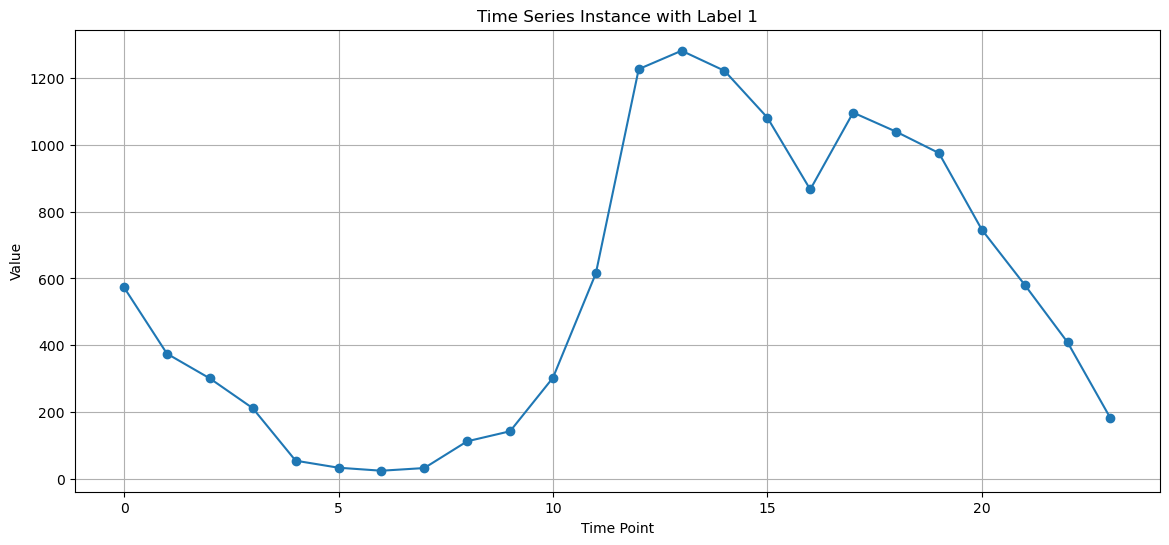

/var/folders/c9/xpcdzsn55474rmzrqh4kx1cw0000gn/T/ipykernel_22389/250865709.py:20: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab10', len(unique_labels))


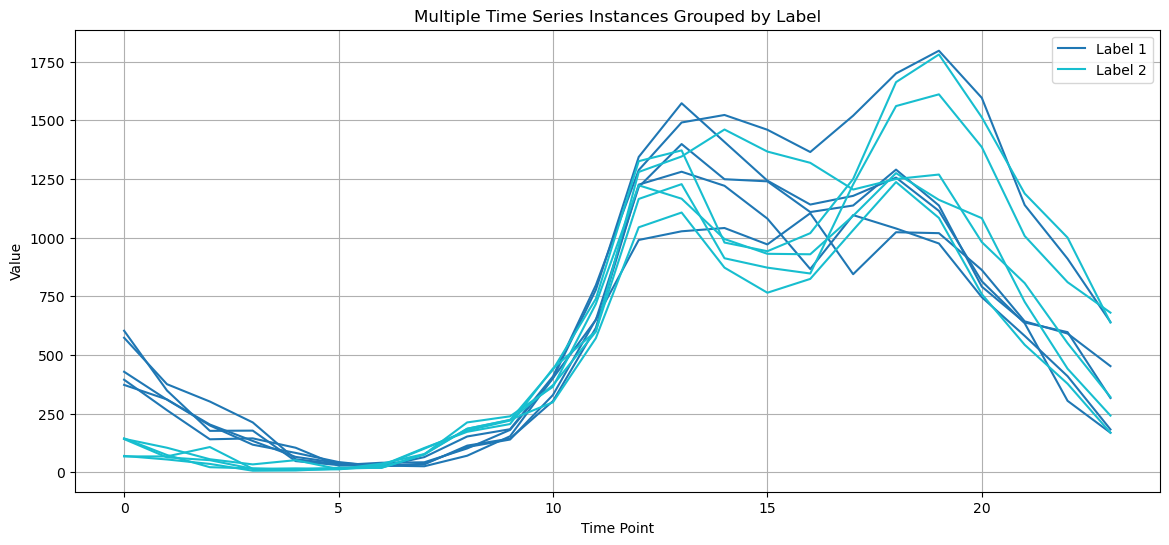

In [22]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming X and y have been defined as shown in previous code examples:
# X: Data in shape (n_instances, n_dimensions, n_timepoints)
# y: Labels in shape (n_instances,)

# Plot a single time series instance
plt.figure(figsize=(14, 6))
plt.plot(X[0, 0, :], marker='o')  # First instance, first dimension
plt.title(f"Time Series Instance with Label {y[0]}")
plt.xlabel('Time Point')
plt.ylabel('Value')
plt.grid(True)
plt.show()

# Plot multiple time series instances with different labels
# Let's select up to 5 instances from each label
unique_labels = np.unique(y)
colors = plt.cm.get_cmap('tab10', len(unique_labels))

plt.figure(figsize=(14, 6))
for i, label in enumerate(unique_labels):
    instances = np.where(y == label)[0]
    selected_instances = instances[:5]  # Select up to 5 instances
    for inst in selected_instances:
        plt.plot(X[inst, 0, :], marker='', color=colors(i), label=f"Label {label}" if inst == selected_instances[0] else "")
plt.title("Multiple Time Series Instances Grouped by Label")
plt.xlabel('Time Point')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()


In [23]:
# COUNT THE NUMBER OF INSTANCES IN EACH CLASS

print("Number of instances per class: ", np.unique(y, return_counts=True)[1])

Number of instances per class:  [104 259]


In [24]:
import numpy as np
import os
import scipy.io.wavfile as wavfile
from sktime.datasets import load_UCR_UEA_dataset

def clear():
    os.system('clear')

## Sound dataset ##
def read_sound_timeseries(file_name, down_sampling_rate=100):
    sample_rate, data = wavfile.read(file_name)
    duration = len(data)/sample_rate
    time = np.arange(0, 1, 1/(duration*sample_rate))
    intervals = np.array(np.arange(0, len(time), len(time)/down_sampling_rate), dtype=int)
    intervals = intervals[:down_sampling_rate]
    data = data[intervals]
    data = np.abs(data)/np.max(np.abs(data))
    return data

def generate_data_from_sound_dataset(input_dir):
    cur_label = 0
    Y, labels = [], []
    for single_dir in os.scandir(input_dir):
        if not single_dir.is_dir():
            continue
        for sound_file in os.scandir(single_dir):
            # Read current timeseries
            data = read_sound_timeseries(sound_file)
            Y.append(data) 
            labels.append(cur_label)
        cur_label += 1
    Y, labels = np.array(Y, dtype=float), np.array(labels, dtype=int)
    return Y.reshape(Y.shape[0], 1, Y.shape[1]), labels+1

## Synthetic data ##
def func_factory(coef, arg):
    def func(x):
        return coef[0] * np.sin(x * arg[0] * np.pi) + coef[1] * np.cos(x * arg[1] * np.pi) +  coef[2] * np.sin(x * arg[2] * np.pi) 
    return func

def generate_synthetic_data(num_samples=np.array([20, 20, 20]), seq_len=10, sigma=0.1): 
    base_X = np.linspace(0, 1, seq_len)

    func1 = func_factory([1.0, 0.3, 0.5], [3, 9, 7])
    func2 = func_factory([0.1, 1, -0.1], [1.5, 6, 7])
    func3 = func_factory([0.5, -1,  0.6], [4.5, 2.5, 9])
    funcs = [func1, func2, func3]

    Y = []; labels = []
    for l in range(0, 3):
        start_ind = 0 if l != 0 else 1
        for _ in range(start_ind, num_samples[l]):
            Y.append(funcs[l](base_X) + np.random.normal(size=seq_len) * sigma)
            labels.append(l)

    Y = np.array(Y); labels = np.array(labels)
    return Y.reshape(Y.shape[0], 1, Y.shape[1]), labels+1

def load_data(name, split='train', add_noise=False):
    '''
    Returns time series data together with corresponding labels. 
    Note we are considering different motions or collections of time series.
    
    Parameters
    ----------
    name: Name of the data set
    split: either train or test data
    '''
    if name == 'Synthetic':
        if split == 'train':
            Y, labels = generate_synthetic_data(num_samples=[30, 30, 30], seq_len=500, sigma=0.1)
        elif split == 'test':
            Y, labels = generate_synthetic_data(num_samples=[20, 20, 20], seq_len=500, sigma=0.1)
    elif name == 'Sound':
        Y, labels = generate_data_from_sound_dataset(input_dir='data/sound')
    else:
        Y, labels= load_UCR_UEA_dataset(name=name, split=split, return_X_y=True, return_type="numpy3d")
    if add_noise:
        Y += np.random.normal(size=Y.shape) * 0.3 * np.max(np.abs(Y))
    return Y, labels

def process_data(Y, labels):
    '''
    Simple data processing for collections of time series.
    Make Y 2d array and normalize labels to [0..L-1], where L is the number of labels.
    '''
    try:
        labels = np.array(labels, dtype=int)
        labels_unique = np.sort(np.unique(labels))
        num_motion = labels_unique.shape[0]
        labels_to_indices = {}
        for k in range(num_motion):
            labels_to_indices[labels_unique[k]] = k
        for i in range(labels.shape[0]):
            labels[i] = labels_to_indices[labels[i]]
    except:
        return np.array([]), np.array([])
    
    return Y[:, 0, :], labels

def add_time_variable(Y, labels, visualize=False):
    '''
    Add the time variable X
    '''
    if len(labels) == 0:
        return np.array([]), np.array([]), np.array([])

    num_samples = Y.shape[0]; seq_len = Y.shape[1]
    X = np.tile(np.linspace(0, 1, seq_len), (num_samples, 1))
    return X, Y, labels

def process_data_for_motion_codes(Y, labels):
    '''
    Data processing specifically for MotionCodes as the algorithm also need a generated time variable X.
    '''
    Y, labels = process_data(Y, labels)
    return add_time_variable(Y, labels)

def split_train_test_forecasting(Y, percentage):
    '''
    Split train and test sets for forecasting.
    '''
    seq_length = Y.shape[1]
    train_num_steps = int(percentage*seq_length)
    test_num_steps = seq_length - train_num_steps
    
    return Y[:, :train_num_steps], Y[:, train_num_steps:], train_num_steps, test_num_steps

In [25]:
import numpy as np
import jax.numpy as jnp
import jax.scipy as jsp

from jax import jit, value_and_grad
from jax.config import config

config.update("jax_enable_x64", True)

# Constants
TWO_PI_SQRT = jnp.sqrt(jnp.pi)

## Helper math fcts ##
def sigmoid(x):
    return 1/(1+jnp.exp(-x))

def sigmoid_inv(y):
    return np.log(y/(1-y))

def softmax(logits):
    exp_logits = jnp.exp(logits)
    return exp_logits/jnp.sum(exp_logits)

def softplus(X):
  return jnp.log(1+jnp.exp(X))

def softplus_inv(X):
  return np.log(np.exp(X)-1)

def jitter(d, value=1e-6):
    return jnp.eye(d)*value

## Methods for finding kernels from data ##
def spectral_kernel(X1, X2, sigma, alpha):
    num_x1 = X1.shape[0]
    num_x2 = X2.shape[0]
    X12 = (X1.reshape(num_x1, 1) - X2.reshape(1, num_x2)).reshape(num_x1, num_x2, 1)
    return jnp.sum(alpha.reshape(1, 1, -1) * jnp.exp(-0.5 * X12 * sigma.reshape(1, 1, -1) * X12), axis=-1)

## Pack/unpack parameters ##
def pack_params(params):
    '''
    Returns a single 1D vector
    
    Parameters
    ----------
    params is a list of parameters
    '''
    flatten = []
    for p in params:
        flatten.extend(p.reshape(-1))
    return np.array(flatten)

def unpack_params_single(params, dims):
    m, Q = dims
    cnt = 0
    X_m = params[cnt:cnt+m]; cnt += m
    Sigma = params[cnt:cnt+Q]; cnt += Q
    W = params[cnt:cnt+Q]; cnt += Q

    return jnp.array(X_m).reshape(m),  Sigma, W

def unpack_params(params, dims):
    '''
    Returns unpacked X_m, Z, Sigma, W
    X_m is a pack of inducing point with shape (m, latent_dim)
    Z is all motion codes stacking together with shape (num_motion, latent_dim)
    (Sigma, W) are kernel params of all motions, each has shape (num_motion, Q)    
    '''
    num_motion, m, latent_dim, Q = dims
    cnt = 0
    X_m = params[cnt:cnt+m*latent_dim]; cnt += m*latent_dim
    Z = params[cnt:cnt+num_motion*latent_dim]; cnt += num_motion*latent_dim
    Sigma = params[cnt:cnt+num_motion*Q]; cnt += num_motion*Q
    Sigma = Sigma.reshape(num_motion, Q)
    W = params[cnt:cnt+num_motion*Q]; cnt += num_motion*Q
    W = W.reshape(num_motion, Q)
  
    return jnp.array(X_m).reshape(m, latent_dim), Z.reshape(num_motion, latent_dim), Sigma, W

## ELBO functions ##
def elbo_fn_from_kernel(K_mm, K_mn, y, trace_avg_all_comps, sigma_y):
    """
    Calculate elbo function from given kernels and y-data
    """
    # n is the number of training samples
    n = y.shape[0]
    L = jnp.linalg.cholesky(K_mm)
    A = jsp.linalg.solve_triangular(L, K_mn, lower=True)/sigma_y
    AAT = A @ A.T
    B = jnp.eye(K_mn.shape[0]) + AAT
    LB = jnp.linalg.cholesky(B)
    c = jsp.linalg.solve_triangular(LB, A.dot(y), lower=True)/sigma_y

    lb = -n/2 * jnp.log(2*jnp.pi)
    lb -= jnp.sum(jnp.log(jnp.diag(LB)))
    lb -= n/2 * jnp.log(sigma_y**2)
    lb -= 0.5/sigma_y**2 * y.T.dot(y)
    lb += 0.5 * c.T.dot(c)
    lb -= 0.5/sigma_y**2 * n * trace_avg_all_comps
    lb += 0.5 * jnp.trace(AAT)

    return -lb[0, 0]

def elbo_fn_single(X, Y, sigma_y, dims):
    """
    Returns ELBO function for a single time series.
    
    Parameters
    ----------
    X: Timeseries's time variable
    Y: Timeseries's target/output variable
    dims = (m, Q)
    """

    def elbo(params):
        # X_m is inducing pt (m, ), Sigma, W are kernel parameters of shape Q
        X_m, Sigma, W = unpack_params_single(params, dims)
        Sigma = softplus(Sigma)
        W = softplus(W)
        K_mm = spectral_kernel(X_m, X_m, Sigma, W) + jitter(X_m.shape[0])
        K_mn = spectral_kernel(X_m, X, Sigma, W)
        trace_avg_all_comps = jnp.sum(W**2)
        y_n_k = Y.reshape(-1, 1)
        
        return elbo_fn_from_kernel(K_mm, K_mn, y_n_k, trace_avg_all_comps, sigma_y)

    elbo_grad = jit(value_and_grad(elbo))

    def elbo_grad_wrapper(params):
        value, grads = elbo_grad(params)
        return np.array(value), np.array(grads)

    return elbo_grad_wrapper

def elbo_fn(X_list, Y_list, labels, sigma_y, dims):
    """
    Returns ELBO function from a list of timeseries with each timeseries is a specific motion.
    
    Parameters
    ----------
    X_list: A list of timeseries's time variable, whose element has shape (n, ).
    Y_list: A list of timeseries's target/output variable, whose element has shape (n, )
    Here n is the number of data points in a particular timeseries.
    labels: map each timeseries to the motion (number) it represents.
    sigma_y: Target noise.
    dims: tuple of (num_motion,  m=num_inducing_pts, latent_dim, Q). Recall Q is the number of terms in kernel.
    """

    def elbo(params):
        # X_m is a pack of inducing point with shape (m, latent_dim)
        # Z is all motion codes stacking together with shape (num_motion, latent_dim)
        # Currently, each motion has a separate set of params (sigma, mu, w, phi, theta)
        # They are stacked in (Sigma, W), with each has shape (num_motion, num_comp, Q)
        X_m, Z, Sigma, W = unpack_params(params, dims)
        Sigma = softplus(Sigma)
        W = softplus(W)

        loss = 0
        for i in range(len(X_list)):
            k = labels[i]  # label of the current timeseries
            X_m_k = sigmoid(X_m@Z[k])
            K_mm = spectral_kernel(X_m_k, X_m_k, Sigma[k], W[k]) + jitter(X_m_k.shape[0])
            K_mn = spectral_kernel(X_m_k, X_list[i], Sigma[k], W[k])
            trace_avg_all_comps = jnp.sum(W[k]**2)
            y_n_k = Y_list[i].reshape(-1, 1) # shape (n, 1)
            loss += elbo_fn_from_kernel(K_mm, K_mn, y_n_k, trace_avg_all_comps, sigma_y)
        
        return loss/len(X_list)

    elbo_grad = jit(value_and_grad(elbo))

    def elbo_grad_wrapper(params):
        value, grads = elbo_grad(params)
        return np.array(value), np.array(grads)

    return elbo_grad_wrapper

## Predict distribution, mean and covariance methods from trained kernel parameters and inducing pts ##
@jit
def phi_opt(X_m, X_list, Y_list, sigma_y, kernel_params):
    """
    Find optimal mu_m and A_m: approximate distribution params for f_m.
    Note that mu_m and A_m are for a single motion with all timeseries data corresponding to that motion.
    
    Parameters
    ----------
    X_m: inducing points of one motion
    X_list: A list of timeseries's time variables for this motion
    Y_list: A list of timeseries's target variable for this motion
    kernel_params: kernel parameters for gaussian approx of this motion
    """
    sigma, alpha= kernel_params

    precision = 1.0/(sigma_y**2)
    B = len(X_list)

    # Get K_mm and its inverse
    K_mm = spectral_kernel(X_m, X_m, sigma, alpha)\
        + jitter(X_m.shape[0])
    K_mm_inv = jnp.linalg.inv(K_mm)
    
    # Get list of K_nm and K_mn
    K_nm_list = []
    K_mn_list = []
    for j in range(B):
        K_nm_list.append(spectral_kernel(X_list[j], X_m, sigma, alpha))
        K_mn_list.append(K_nm_list[j].T)

    # Get Sigma in mean and variance formulas
    Lambda = K_mm
    for j in range(B):
        Lambda += precision/B * K_mn_list[j] @ K_nm_list[j]
    Sigma = jnp.linalg.inv(Lambda)
    factor = 1/B*precision*K_mm @ Sigma

    # Calculate variance
    A_m = K_mm @ Sigma @ K_mm

    # Calculate mean
    y_n = Y_list[0]
    mu_m = (factor @ K_mn_list[0]).dot(y_n)
    for j in range(1, B):
        y_n = Y_list[j]
        mu_m += (factor @ K_mn_list[j]).dot(y_n)

    return mu_m, A_m, K_mm_inv

@jit
def q(X_test, X_m, kernel_params, mu_m, A_m, K_mm_inv):
    """
    Distribution prediction for a new collection of time variables
    """
    sigma, alpha = kernel_params
    K_ss = spectral_kernel(X_test, X_test, sigma, alpha)
    K_sm = spectral_kernel(X_test, X_m, sigma, alpha)
    K_ms = K_sm.T

    f_q = (K_sm @ K_mm_inv).dot(mu_m)
    f_q_cov = K_ss - K_sm @ K_mm_inv @ K_ms + K_sm @ K_mm_inv @ A_m @ K_mm_inv @ K_ms

    return f_q, f_q_cov

In [26]:
import numpy as np
import pandas as pd
from scipy.optimize import minimize
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

# Color list for plotting
COLOR_LIST = ['red', 'blue', 'green', 'orange', 'purple', 'black', 'brown', 'grey', 'yellow', 'black', 'hotpink']

## Metric utils ##
def accuracy(pred, gt):
    """
    Return accuracy metric
    """
    return np.sum(np.array(pred)==np.array(gt))/len(pred)

def RMSE(pred, gt):
    """
    Return root-mean-squared error
    """
    return np.sqrt(np.mean((pred-gt)**2))

## Forecast helper functions given the model ##
def forecast_means_vars(forecaster, Y_train, labels, test_num_steps, num_motion):
    means = [[] for _ in range(num_motion)]
    stds = [[] for _ in range(num_motion)]
    fh = np.arange(1, test_num_steps + 1)
    num_samples = Y_train.shape[0]
    for i in range(num_samples):
        forecaster.fit(pd.Series(Y_train[i]))
        means[labels[i]].append(forecaster.predict(fh).to_numpy())
        stds[labels[i]].append(np.sqrt(forecaster.predict_var(fh).to_numpy().reshape(-1)))
    
    avg_means = [np.mean(np.array(means[k]), axis=0) for k in range(num_motion)]
    avg_stds = [np.mean(np.array(stds[k]), axis=0) for k in range(num_motion)]
    return avg_means, avg_stds

def forecast_mean_vars_motion_codes(model, test_time_horizon):
    # Average prediction for each type of motion.
    X_m, Z = model.X_m, model.Z
    means = []; stds = []
    X_m_ks = []
    for k in range(model.num_motion):
        X_m_k = sigmoid(X_m @ Z[k])
        X_m_ks.append(X_m_k)
        mean, covar = model.forecast_predict(test_time_horizon, k)
        means.append(mean); stds.append(np.sqrt(np.diag(covar)).reshape(-1))
    return means, stds

## Plotting utils ##
def plot_timeseries(X_list, y_list, labels, label_names=[], output_file='out/plot.png'):
    # Plot timeseries
    num_series = len(y_list)
    L = len(np.unique(labels))
    if len(label_names) == 0:
        label_names = [str(i) for i in range(L)]
    is_legend_drawn = [False for _ in range(L)]
    for i in range(num_series):
        label = labels[i]
        if not is_legend_drawn[label]:
            plt.plot(X_list[i], y_list[i], c=COLOR_LIST[labels[i]], lw=0.5, label=label_names[label])
            is_legend_drawn[label] = True
        else:
            plt.plot(X_list[i], y_list[i], c=COLOR_LIST[labels[i]], lw=0.5)
    plt.legend(fontsize='10')
    plt.savefig(output_file)
    plt.clf()

def plot_motion_codes(X_train, Y_train, test_time_horizon, labels, label_names,
                           model, output_dir='out/multiple/'):
    # Get prediction and inducing points
    num_motion = np.unique(labels).shape[0]
    means, stds = means, stds = forecast_mean_vars_motion_codes(model, test_time_horizon)
    X_m, Z = model.X_m, model.Z
    X_m_ks = [sigmoid(X_m @ Z[k]) for k in range(num_motion)]

    # Plot individual stochastic process with motion code prediction and inducing pts
    if len(label_names) == 0:
        label_names = [str(i) for i in range(num_motion)]
    for k in range(num_motion):
        X = X_train[labels==k, :]
        Y = Y_train[labels==k, :]
        plt.plot(X[0], Y[0], c=COLOR_LIST[k], lw=0.5, zorder=1, label=label_names[k])
        for i in range(1, X.shape[0]):
            plt.plot(X[i], Y[i], c=COLOR_LIST[k], lw=0.5, zorder=1)
        std = stds[k]; mean = means[k]
        color = COLOR_LIST[(k+1)%num_motion]
        plt.plot(test_time_horizon, mean, c=color, lw=2, 
                 zorder=1, label='Mean prediction')
        plt.fill_between(test_time_horizon, mean+2*std, mean-2*std,
            color=COLOR_LIST[(k+1)%num_motion], alpha=0.1, zorder=1)
        Y_test = np.interp(X_m_ks[k], X[0], np.mean(Y, axis=0))
        plt.scatter(X_m_ks[k], Y_test, color=color, s=20, zorder=2, label='Inducing values')
        handle_list, _ = plt.gca().get_legend_handles_labels()
        handle_list.append(mpatches.Patch(color=COLOR_LIST[(k+1)%num_motion], 
                                          label='Uncertainty region'))
        plt.legend(handles=handle_list, fontsize='10', loc ="lower left")
        plt.savefig(output_dir + str(k) + '.png')
        plt.clf()

def plot_mean_covars(X_train, Y_train, Y_test, labels, label_names, 
                     test_time_horizon, forecasters, output_dir='out/multiple/'):
    num_motion = np.unique(labels).shape[0]
    if len(label_names) == 0:
        label_names = [str(i) for i in range(num_motion)]
    test_num_steps = test_time_horizon.shape[0]
    all_means = [{} for _ in range(num_motion)]
    all_stds = [{} for _ in range(num_motion)]
    for forecaster, forecaster_name in forecasters:
        if forecaster_name == 'Motion code':
            means, stds = forecast_mean_vars_motion_codes(forecaster, test_time_horizon)
        else:
            means, stds = forecast_means_vars(forecaster, Y_train, labels, test_num_steps, num_motion)
        for k in range(num_motion):
            all_means[k][forecaster_name] = means[k]
            all_stds[k][forecaster_name] = stds[k]
    num_forecaster = len(forecasters)
    for k in range(num_motion):
        X = X_train[labels==k, :]
        Y = Y_train[labels==k, :]
        truth_value = np.mean(Y_test[labels==k, :], axis=0)
        plt.plot(X[0], Y[0], c=COLOR_LIST[num_forecaster], lw=0.5, zorder=1, label=label_names[k])
        for i in range(1, X.shape[0]):
            plt.plot(X[i], Y[i], c=COLOR_LIST[num_forecaster], lw=0.5, zorder=1)
        # True value
        plt.plot(test_time_horizon, truth_value, 
                 c=COLOR_LIST[num_forecaster], lw=2, zorder=1, label='True value')
        cnt = 0
        for _, forecaster_name in forecasters:
            std = all_stds[k][forecaster_name]; mean = all_means[k][forecaster_name]
            color = COLOR_LIST[cnt]
            plt.plot(test_time_horizon, mean, c=color, lw=2, 
                     zorder=1, label='Mean prediction by ' + forecaster_name)
            plt.fill_between(test_time_horizon, mean+2*std, mean-2*std,
                color=color, alpha=0.1, zorder=1)
            cnt += 1

        handle_list, _ = plt.gca().get_legend_handles_labels()
        for i in range(num_forecaster):
            _, name = forecasters[i]
            handle_list.append(mpatches.Patch(color=COLOR_LIST[i], label='Uncertainty region by ' + name))
        plt.legend(handles=handle_list, fontsize='8', loc ="lower left")
        M = 1.1*max(np.max(np.abs(Y_train)), np.max(np.abs(Y_test)))
        plt.ylim(-M, M)
        plt.savefig(output_dir + str(k) + '.png')
        plt.clf()

## Get sparse GP inducing points for individual series
def get_inducing_pts_for_individual_series(m, Q, data, num_motion):
    X_train, Y_train, labels_train, X_test, Y_test, labels_test = data
    # Initialize parameters
    X_m_start = sigmoid_inv(np.linspace(0.1, 0.9, m))
    Sigma_start = softplus_inv(np.ones(Q))
    W_start = softplus_inv(np.ones(Q))

    X_m_list = [[] for _ in range(2*num_motion)]
    dims = (m, Q)
    for i in range(X_train.shape[0] + X_test.shape[0]):
        if i < X_train.shape[0]:
            X = X_train[i]; Y = Y_train[i]
        else:
            X = X_test[i-X_train.shape[0]]; Y = Y_test[i-X_train.shape[0]]
        # Optimize X_m, and kernel parameters including Sigma, W
        res = minimize(fun=elbo_fn_single(X, Y, sigma_y=0.1, dims=dims),
                        x0 = pack_params([X_m_start, Sigma_start, W_start]),
                        method='L-BFGS-B', jac=True)
        X_m, _, _ = unpack_params_single(res.x, dims=dims)
        if i < X_train.shape[0]:
            X_m_list[labels_train[i]].append(X_m)
        else:
            X_m_list[labels_test[i-X_train.shape[0]] + num_motion].append(X_m) 
        
    return X_m_list

In [27]:
import numpy as np
import jax.numpy as jnp
from scipy.optimize import minimize


def optimize_motion_codes(X_list, Y_list, labels, model_path, m=10, Q=8, latent_dim=3, sigma_y=0.1):
    '''
    Main algorithm to optimize all variables for the Motion Code model.
    '''
    num_motion = np.unique(labels).shape[0]
    dims = (num_motion, m, latent_dim, Q)

    # Initialize parameters
    X_m_start = np.repeat(sigmoid_inv(np.linspace(0.1, 0.9, m)).reshape(1, -1), latent_dim, axis=0).swapaxes(0, 1)
    Z_start = np.ones((num_motion, latent_dim))
    Sigma_start = softplus_inv(np.ones((num_motion, Q)))
    W_start = softplus_inv(np.ones((num_motion, Q)))

    # Optimize X_m, Z, and kernel parameters including Sigma, W
    res = minimize(fun=elbo_fn(X_list, Y_list, labels, sigma_y, dims),
        x0 = pack_params([X_m_start, Z_start, Sigma_start, W_start]),
        method='L-BFGS-B', jac=True)
    X_m, Z, Sigma, W = unpack_params(res.x, dims=dims)
    Sigma = softplus(Sigma)
    W = softplus(W)

    # We now optimize distribution params for each motion and store means in mu_ms, covariances in A_ms, and for convenient K_mm_invs
    mu_ms = []; A_ms = []; K_mm_invs = []

    # All timeseries of the same motion is put into a list, an element of X_motion_lists and Y_motion_lists
    X_motion_lists = []; Y_motion_lists = []
    for _ in range(num_motion):
        X_motion_lists.append([]); Y_motion_lists.append([])
    for i in range(len(Y_list)):
        X_motion_lists[labels[i]].append(X_list[i])
        Y_motion_lists[labels[i]].append(Y_list[i])

    # For each motion, using trained kernel parameter in "pair" form to obtain optimal distribution params for each motion.
    for k in range(num_motion):
        kernel_params = (Sigma[k], W[k])
        mu_m, A_m, K_mm_inv = phi_opt(sigmoid(X_m@Z[k]), X_motion_lists[k], Y_motion_lists[k], sigma_y, kernel_params) 
        mu_ms.append(mu_m); A_ms.append(A_m); K_mm_invs.append(K_mm_inv)
    
    # Save model to path.
    model = {'X_m': X_m, 'Z': Z, 'Sigma': Sigma, 'W': W, 
             'mu_ms': mu_ms, 'A_ms': A_ms, 'K_mm_invs': K_mm_invs}
    np.save(model_path, model)
    return

def classify_predict_helper(X_test, Y_test, kernel_params_all_motions, X_m, Z, mu_ms, A_ms, K_mm_invs, mode='dt'):
    """
    Classify by calculate distance between inducing (mean) values and interpolated test values at inducing pts.
    """
    num_motion = len(kernel_params_all_motions)
    ind = -1; min_ll = 1e9
    for k in range(num_motion):
        X_m_k = sigmoid(X_m @ Z[k])
        if mode == 'simple':
            Y = np.interp(X_m_k, X_test, Y_test)
            ll = ((mu_ms[k]-Y).T)@(mu_ms[k]-Y)
        elif mode == 'variational':
            Sigma, W = kernel_params_all_motions[k]
            K_mm = spectral_kernel(X_m_k, X_m_k, Sigma, W) + jitter(X_m_k.shape[0])
            K_mn = spectral_kernel(X_m_k, X_test, Sigma, W)
            trace_avg_all_comps = jnp.sum(W**2)
            y_n_k = Y_test.reshape(-1, 1) # shape (n, 1)
            ll = elbo_fn_from_kernel(K_mm, K_mn, y_n_k, trace_avg_all_comps, sigma_y=0.1)
        elif mode == 'dt':
            mean, _ = q(X_test, X_m_k, kernel_params_all_motions[k], mu_ms[k], A_ms[k], K_mm_invs[k])
            # ll = jnp.log(jnp.linalg.det(covar)) + ((Y_test-mean).T)@jnp.linalg.inv(covar)@(Y_test-mean)
            ll = ((mean-Y_test).T)@(mean-Y_test) 
        if ind == -1:
            ind = k; min_ll = ll
        elif min_ll > ll: 
            ind = k; min_ll = ll
    
    return ind

In [28]:
import time
from tqdm import tqdm
import numpy as np

class MotionCode:
    """
    Class for motion code model

    Attributes
    ----------
    m: int
        Number of inducing points
    Q: int
        Number of kernel components
    latent_dim: int
        Dimension of motion codes
    sigma_y: float
        Noise of the target variable
    model_path: str
        Path to save/load the model
    num_motion: int
        Number of stochastic processes the model considered
    X_m: numpy.ndarray
        The common transformation for all stochastic processes underlying collections of time series data
    Z: numpy.ndarray
        Stacked motion codes
    Sigma: numpy.ndarray
        Stacked kernel parameters for the exponents of all stochastic processes
    W: numpy.ndarray
        Stacked kernel parameters for the scales of all stochastic processes
    kernel_params:
        Stacked pairs of kernel parameters (Sigma, W) for all stochastic processes
    mu_ms: numpy.ndarray
        Stacked mean prediction over the inducing points for all stochastic processes
    A_ms: numpy.ndarray
        Stacked covariance of mu_ms for all stochastic processes
    K_mm_invs: numpy.ndarray
        Stacked inverses of the kernel over inducing points for all stochastic processes
        
    Methods
    -------
    fit(X_train, Y_train, labels_train, model_path)
        Train model on `(X_train, Y_train)` time series with collection labels `labels_train`
        and then save model to `model_path`

    load(model_path='')
        Load model at `model_path`
    classify_predict(X_test, Y_test):
        Predict the label for a single time series `(X_test, Y_test)` in classification problem.

    classify_predict_on_batches(X_test_list, Y_test_list, true_labels)
        Predict the labels for a list of time series `(X_test_list, Y_test_list)`
        and then compare against `true_labels` and return accuracy

    forecast_predict(self, test_time_horizon, label)
        Predict future values on `test_time_horizon` for stochastic process with label `label`
    
    forecast_predict_on_batches(self, test_time_horizon, Y_test_list, labels)
        Predict future (mean) values on `test_time_horizon` for all stochastic processes
        and then use the results to compare against the time series list `Y_test_list` with labels `labels`
        for RMSE errors.

    """
    def __init__(self, m=10, Q=1, latent_dim=2, sigma_y=0.1):
        self.m = m # Num inducing pts
        self.Q = Q # Num of kernel components
        self.latent_dim = latent_dim # Dim of motion code
        self.sigma_y = sigma_y # Noise of target

    def fit(self, X_train, Y_train, labels_train, model_path):
        start_time = time.time()
        self.model_path = model_path
        optimize_motion_codes(X_train, Y_train, labels_train, model_path=model_path, 
              m=self.m, Q=self.Q, latent_dim=self.latent_dim, sigma_y=self.sigma_y)
        self.train_time = time.time() - start_time

    def load(self, model_path=''):
        if len(model_path) == 0 and self.model_path is not None:
            model_path = self.model_path
        params = np.load(model_path + '.npy', allow_pickle=True).item()
        self.X_m, self.Z, self.Sigma, self.W = params.get('X_m'), params.get('Z'), params.get('Sigma'), params.get('W') 
        self.mu_ms, self.A_ms, self.K_mm_invs = params.get('mu_ms'), params.get('A_ms'), params.get('K_mm_invs')
        self.num_motion = self.Z.shape[0]
        self.kernel_params = []
        for k in range(self.num_motion):
            self.kernel_params.append((self.Sigma[k], self.W[k]))

    def classify_predict(self, X_test, Y_test):
        return classify_predict_helper(X_test, Y_test, self.kernel_params, 
                                       self.X_m, self.Z, self.mu_ms, self.A_ms, self.K_mm_invs)
    
    def classify_predict_on_batches(self, X_test_list, Y_test_list, true_labels):
        # Predict each trajectory/timeseries in the test dataset
        num_predicted = 0
        pred = []; gt = []
        pbar = tqdm(zip(X_test_list, Y_test_list), total=Y_test_list.shape[0], leave=False)
        num_predicted = 0
        for X_test, Y_test in pbar:
            # Get predict and ground truth motions
            pred_label = self.classify_predict(X_test, Y_test)
            gt_label = true_labels[num_predicted]
            pbar.set_description(f'Predict: {pred_label}; gt: {gt_label}')
            # Append results to lists for final evaluation
            pred.append(pred_label); gt.append(gt_label)
            num_predicted += 1

        # Accurary evaluation
        return accuracy(pred, gt)
    
    def forecast_predict(self, test_time_horizon, label):
        k = label
        return q(test_time_horizon, sigmoid(self.X_m @ self.Z[k]), 
                 self.kernel_params[k], self.mu_ms[k], self.A_ms[k], self.K_mm_invs[k])
    
    def forecast_predict_on_batches(self, test_time_horizon, Y_test_list, labels):
        # Average prediction for each type of motion.
        mean_preds = []
        for k in range(self.num_motion):
            mean, _ = self.forecast_predict(test_time_horizon, label=k)
            mean_preds.append(mean)
        
        all_errors = [[] for _ in range(self.num_motion)]
        
        for i in range(len(Y_test_list)):
            label = labels[i]
            all_errors[label].append(RMSE(mean_preds[label], Y_test_list[i]))

        errs = np.zeros(self.num_motion)
        for i in range(self.num_motion):
            errs[i] = np.mean(np.array(all_errors[i]))
        
        return errs

## Convenient functions that combine train, load, test, report errors.
def motion_code_classify(model, name, Y_train, labels_train, Y_test, labels_test, load_existing_model=False):
    # Train
    X_train, Y_train, labels_train = process_data_for_motion_codes(Y_train, labels_train)
    model_path = 'saved_models/' + name + '_classify'
    if not load_existing_model:
        model.fit(X_train, Y_train, labels_train, model_path)
    # Test
    model.load(model_path)
    X_test, Y_test, labels_test = process_data_for_motion_codes(Y_test, labels_test)
    acc = model.classify_predict_on_batches(X_test, Y_test, labels_test)
    return acc

def motion_code_forecast(model, name, percentage, load_existing_model=False):
    # Train/test for forecasting on the training set but split on time horizon
    Y_train, labels_train = load_data(name, split='train')
    X, Y, labels = process_data_for_motion_codes(Y_train, labels_train)
    
    # Split train/test wrt time horizon
    Y_train, Y_test, train_num_steps, _ = split_train_test_forecasting(Y, percentage)
    X_train = X[:, :train_num_steps] # Motion code need addition X variable
    test_time_horizon = X[0, train_num_steps:]

    # Train/test
    model_path = 'saved_models/' + name + '_forecast'
    if not load_existing_model:
        model.fit(X_train, Y_train, labels, model_path)
    model.load(model_path)
    err = model.forecast_predict_on_batches(test_time_horizon, Y_test, labels)

    return err

In [29]:
# In this example, we use ItalyPowerDemand dataset. First we load dataset include Y-values of the series and their labels
name = 'ItalyPowerDemand'
Y_train, labels_train = load_data(name=name, split='train')

# Then we process the data for motion code model and generate X-variable, which is needed for training.
X_train, Y_train, labels_train = process_data_for_motion_codes(Y_train, labels_train)

# Now we load the test set
Y_test, labels_test = load_data(name=name, split='test')
X_test, Y_test, labels_test = process_data_for_motion_codes(Y_test, labels_test)

print(X_train.shape, Y_train.shape, labels_train.shape)
print(X_test.shape, Y_test.shape, labels_test.shape)

(67, 24) (67, 24) (67,)
(1029, 24) (1029, 24) (1029,)


/usr/local/Caskroom/miniforge/base/envs/torch/lib/python3.11/site-packages/sktime/datatypes/_panel/_convert.py:74: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  return X.applymap(_cell_is_series_or_array)
/usr/local/Caskroom/miniforge/base/envs/torch/lib/python3.11/site-packages/sktime/datatypes/_panel/_convert.py:889: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  X.applymap(_convert_series_cell_to_numpy)
/usr/local/Caskroom/miniforge/base/envs/torch/lib/python3.11/site-packages/sktime/datatypes/_panel/_convert.py:74: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  return X.applymap(_cell_is_series_or_array)
/usr/local/Caskroom/miniforge/base/envs/torch/lib/python3.11/site-packages/sktime/datatypes/_panel/_convert.py:889: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  X.applymap(_convert_series_cell_to_numpy)


In [30]:
# Next we build the default motion code model for both forecasting and classification
model = MotionCode(m=10, Q=1, latent_dim=2, sigma_y=0.1)

# Then we train model on the given X_train, Y_train, label_train set and saved it to a file named test_model.
model_path = 'saved_models/' + 'test_model'
model.fit(X_train, Y_train, labels_train, model_path)

FileNotFoundError: [Errno 2] No such file or directory: 'saved_models/test_model.npy'

In [ ]:
import numpy as np

# Next we load the model and perform classification on 10 random test time series.
model.load(model_path)
num_test = labels_test.shape[0]
random_indices = np.random.choice(np.arange(num_test), size=10, replace=False)
predicted_labels = []
for ind in random_indices:
    predicted_labels.append(model.classify_predict(X_test[ind], Y_test[ind]))
print('True label:', list(labels_test[random_indices]))
print('Predicted label:', predicted_labels)

True label: [0, 1, 1, 1, 0, 1, 0, 0, 0, 1]
Predicted label: [0, 1, 1, 1, 0, 1, 0, 0, 0, 1]


In [ ]:
# Now we can go on to perform prediction on the whole test set and get accuracy
acc = model.classify_predict_on_batches(X_test_list=X_test, Y_test_list=Y_test, true_labels=labels_test)
print('Accurary:', acc)

Accurary: 0.9115646258503401


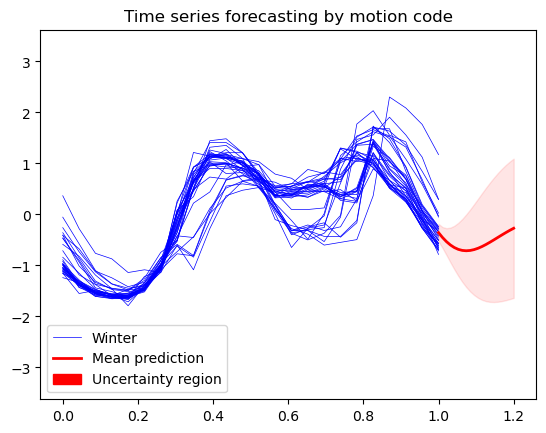

In [ ]:
# Next we can use the same model to make prediction on a future interval.
# The X-variable in the previous cell is normalized to [0, 1]
# Note that the model make a average prediction over the whole collection of time series
# The prediciton is therefore made for the underlying stochastic process and not for the individual time series

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

# We predict on test time horizon [1, 1.2] with 20 time steps
test_time_horizon = np.linspace(1, 1.2, 20)

# label is the label for the stochastic process we predict
mean, covar = model.forecast_predict(test_time_horizon, label=0)
std = np.sqrt(np.diag(covar)).reshape(-1)

# We plot all the time series on the horizon [0, 1]
X = X_train[labels_train==0, :]
Y = Y_train[labels_train==0, :]
plt.plot(X[0], Y[0], c='blue', lw=0.5, zorder=1, label='Winter')
for i in range(1, X.shape[0]):
    plt.plot(X[i], Y[i], c='blue', lw=0.5, zorder=1)

# Then we plot our prediction with uncertainty on test time horizon = [1, 1.2]
plt.plot(test_time_horizon, mean, c='red', lw=2, zorder=1, label='Mean prediction')
plt.fill_between(test_time_horizon, mean+2*std, mean-2*std, color='red', alpha=0.1, zorder=1)

# Plot setting and plot show
handle_list, _ = plt.gca().get_legend_handles_labels()
handle_list.append(mpatches.Patch(color='red', label='Uncertainty region'))
plt.legend(handles=handle_list, fontsize='10', loc ="lower left")
M = 1.1*max(np.max(np.abs(Y_train)), np.max(np.abs(Y_test)))
plt.ylim(-M, M)
plt.title('Time series forecasting by motion code')
plt.show()

In [ ]:
# Now we already know how to use Motion Code. 
# Next we run Motion Code on 14 noisy data sets for classification tasks and report the accuracy.
# We already haved trained model, so you can load the model directly to save time.
datasets = ['Chinatown', 'ECGFiveDays', 'FreezerSmallTrain', 'GunPointOldVersusYoung', 'HouseTwenty', 'InsectEPGRegularTrain', 
            'ItalyPowerDemand', 'Lightning7', 'MoteStrain', 'PowerCons', 'SonyAIBORobotSurface2', 'Sound', 'Synthetic', 
            'UWaveGestureLibraryAll']

for name in datasets:
    # Load noisy data
    data_path = 'data/noisy/' + name
    data = np.load(data_path + '.npy', allow_pickle=True).item()
    Y_test, labels_test = data.get('X_test'), data.get('y_test')
    X_test, Y_test, labels_test = process_data_for_motion_codes(Y_test, labels_test)
    
    # Load existing model. You can train again if you want to.
    model_path = 'saved_models/' + name + '_classify'
    model.load(model_path)
    
    # Classify on batches and return accuracy
    acc = model.classify_predict_on_batches(X_test, Y_test, labels_test)
    print('Dataset %s has accurary %.2f %%.' % (name, acc*100))

FileNotFoundError: [Errno 2] No such file or directory: 'data/noisy/Chinatown.npy'

## Introduction and Theoretical Background

### Governing Equation for Transient Water Flow in a Discretized Porous Medium

The transport of fluid, particularly water, through porous media is a critical process in various applications ranging from reservoir engineering to environmental science. In this context, a discretized representation of a porous medium is often employed for numerical simulation. The mathematical model for transient water flow in such a medium is encapsulated in the following partial differential equation (PDE):

$$
\begin{equation}
\underbrace{\Big[\Phi_{\text{ref}} V \left( \frac{\partial m_\phi(p)}{\partial p} b(p) + m_\phi(p) \frac{\partial b(p)}{\partial p} \right) \frac{dp}{dt} \Big]_i}_{\text{Transient term in block }i, \, \left[\frac{m^3}{s} \right]}
+ \underbrace{\sum_{j \in C(i)} \left[ \left[b(p) \lambda m_T(p) \right]_i T_{ij} (p_{i} - p_{j}) \right]}_{\text{Flow between connected blocks}, \, \left[\frac{m^3}{s} \right]}
+ \underbrace{T_{w,i}M_{i} (p_i - p_{bhp,w})}_{\text{Inflow into well within block }i, \, \left[\frac{m^3}{s} \right]} = 0
\end{equation}
$$

The equation comprises three primary components:

1. **Transient Term**: This term accounts for the changes in fluid storage within a discrete block $ i $, captured through variables like pore volume multiplier $ m_\phi $, formation volume factor $ b $, and the rate of pressure change $ \frac{dp}{dt} $.

2. **Inter-Block Flow Term**: This term describes the fluid exchange between connected blocks $ i $ and $ j $, influenced by the transmissibility $ T_{ij} $ and pressure difference $ p_i - p_j $.

3. **Well Inflow Term**: This term quantifies the influence of a wellbore within block $ i $, contributing to the inflow or outflow based on the pressure difference between the cell and the well's bottomhole pressure $ p_{bhp,w} $.

### Initial Conditions

To solve this equation in a time-dependent context, initial conditions are indispensable. We assume a spatially homogeneous initial condition, with constant pressure $ p_i = \text{const} $ prevailing across all cells $ i $.

### Nomenclature with Units

- $ \Phi_{\text{ref,i}} $: Reference porosity in cell $ i $, dimensionless.
- $ V_i $: Volume of cell $ i $, $ m^3 $.
- $ m_{\phi,i} $: Pore volume multiplier in cell $ i $, dimensionless.
- $ b_i $: Formation volume factor; essentially a ratio relating the volume of fluid in reservoir conditions to that at surface conditions, $ m^3/m^3 $.
- $ C(i) $: Set of cells directly connected to cell $ i $.
- $ \lambda $: Mobility of the water phase, $ m^2/\text{Pa} \cdot s $.
- $ m_{T,i} $: Transmissibility multiplier in cell $ i $, dimensionless.
- $ T_{ij} $: Transmissibility factor between cells $ i $ and $ j $, $ m^2/\text{Pa} \cdot s $.
- $ p_i $: Pressure in cell $ i $, Pa.
- $ T_{w,i} $: Transmissibility of the well connection in cell $ i $, $ m^2/\text{Pa} \cdot s $.
- $ M_{i} $: Mobility of the water phase in the well connection at cell $ i $, $ m^2/\text{Pa} \cdot s $.
- $ p_{bhp,w} $: Bottomhole pressure of the well, Pa.

### 1. Transient Term in Block $i$

$$
\underbrace{\Big[\Phi_{\text{ref}} V \left( \frac{\partial m_\phi(p)}{\partial p} b(p) + m_\phi(p) \frac{\partial b(p)}{\partial p} \right) \frac{dp}{dt} \Big]_i}_{\text{Transient term in block }i, \, \left[\frac{m^3}{s} \right]}
$$

**Explanation:**

This term captures the change in water volume within a grid block as time progresses. It is termed as the 'transient' term because it accounts for the time-varying accumulation or depletion of water within the cell. Specifically:

- $ \Phi_{\text{ref}} $: Reference porosity defines the initial proportion of the volume in the rock that is occupied by the fluid. It represents the inherent porosity of the rock.
  
- $ V $: Volume of the grid cell. This, in combination with porosity, gives us the total pore volume.

- $ m_\phi(p) $: This is the pore volume multiplier. It gives the change in pore volume due to pressure changes. The derivative $\frac{\partial m_\phi(p)}{\partial p}$ gives the rate of change of this multiplier with respect to pressure, showing how sensitive the pore volume is to pressure changes.

- $ b(p) $: This is the formation volume factor. It tells us how much volume a given amount of water at reservoir conditions would occupy at the surface. Its derivative $\frac{\partial b(p)}{\partial p}$ gives the rate of change of the formation volume factor with pressure.

- $ \frac{dp}{dt} $: This represents the rate of change of pressure with time in the grid block.

Combining these components, this term provides the rate of change of water volume in the grid cell with time, incorporating the effects of porosity, pore volume changes due to pressure, and formation volume factor changes.

---

### 2. Flow Between Connected Blocks

$$
\underbrace{\sum_{j \in C(i)} \left[ \left[b(p) \lambda m_T(p) \right]_i T_{ij} (p_{i} - p_{j}) \right]}_{\text{Flow between connected blocks}, \, \left[\frac{m^3}{s} \right]}
$$

**Explanation:**

This term models the flow of water between neighboring grid blocks. The flow is driven by pressure differences between the blocks and is moderated by the transmissibility between them. Specifically:

- $ \lambda $: This is the mobility of the water phase, which indicates how easily the water can flow. It's a combination of permeability and viscosity.

- $ m_T(p) $: This is the transmissibility multiplier, which can vary with pressure.

- $ T_{ij} $: This represents the transmissibility between blocks $i$ and $j$. It encapsulates the inherent ability of the two blocks to transmit fluid between them based on the properties of the rock and fluid.

- $ (p_{i} - p_{j}) $: The pressure difference between blocks $i$ and $j$. The flow is from a region of higher pressure to a region of lower pressure.

---

### 3. Inflow Into Well Within Block $i$

$$
\underbrace{T_{w,i}M_{i} (p_i - p_{bhp,w})}_{\text{Inflow into well within block }i, \, \left[\frac{m^3}{s} \right]}
$$

**Explanation:**

This term models the inflow (or outflow) of water to (or from) a well that is connected to block $i$. The flow is driven by the pressure difference between the block and the well's bottomhole pressure. Specifically:

- $ T_{w,i} $: Transmissibility of the well connection in block $i$. It represents the capacity of the wellbore in that block to allow fluid flow.

- $ M_{i} $: Mobility of the water phase in the well connection at block $i$.

- $ (p_i - p_{bhp,w}) $: The pressure difference between the grid block $i$ and the bottomhole pressure of the well. The fluid will flow into or out of the well based on this difference.


### Gaussian Process Adaptation for Decline Curve Analysis

Decline Curve Analysis (DCA) is a pivotal tool in the oil and gas industry for forecasting production rates and estimating reserves. The method involves fitting a model to production time series data, traditionally characterized by empirical decline laws:

1. **Exponential decline**, where the production rate decreases at a constant percentage rate.
2. **Harmonic decline**, with the decline rate decreasing as the inverse of time.
3. **Hyperbolic decline**, which can transition from a steeper decline to a harmonic decline.

Mathematically, these decline behaviors are often represented by functions such as:

$$
q(t) = \frac{q_i}{(1 + b D_i t)^{1/b}},
$$

where $ q(t) $ is the production rate at time $ t $, $ q_i $ is the initial production rate, $ D_i $ is the initial decline rate, and $ b $ is the decline curve exponent, distinguishing different decline trends.

#### Gaussian Process (GP) Framework

Incorporating Gaussian Processes into DCA allows for a probabilistic treatment of the time series. A GP assumes that the observed data can be modeled as samples from a multivariate Gaussian distribution. Given a set of observations $ \mathbf{y} $ at times $ \mathbf{t} $, we have:

$$
\mathbf{y} \sim \mathcal{N}(\mathbf{m}(\mathbf{t}), \mathbf{K}(\mathbf{t}, \mathbf{t}')),
$$

where $ \mathbf{m}(\mathbf{t}) $ is the mean function (often taken as zero for simplicity) and $ \mathbf{K}(\mathbf{t}, \mathbf{t}') $ is the covariance matrix determined by the kernel function encapsulating the decline behavior.

#### Motion Codes and Inducing Points

Adapting motion codes to DCA, they symbolize latent variables capturing the unique decline trajectories of wells. These are analogous to motion types in our previous discussion. The inducing points $ X_m $ compress information akin to a sparse representation in GP regression, enhancing computational efficiency.

To predict future production rates with uncertainty quantification, we solve for:

$$
\log p(\mathbf{y} \mid \mathbf{X}, \mathbf{z}, \boldsymbol{\eta}) \geq \mathcal{L}(\mathbf{X}_m \mathbf{z}, \boldsymbol{\eta}) - \lambda \| \mathbf{z} \|^2,
$$

where $ \mathbf{X}_m \mathbf{z} $ represents the inducing points weighted by the motion codes $ \mathbf{z} $, and $ \boldsymbol{\eta} $ are the kernel hyperparameters optimized to reflect the decline trends. The term $ \lambda \| \mathbf{z} \|^2 $ regularizes the motion codes, promoting sparsity and robustness to noise.

#### Inference and Uncertainty

The GP predictive distribution for new time points $ \mathbf{t}^* $ yields both the mean function values $ \mathbf{m}(\mathbf{t}^*) $ and variance $ \mathbf{K}(\mathbf{t}^*, \mathbf{t}^*) $, providing a forecast with quantified uncertainty.

This GP-based adaptation to DCA offers a data-driven, probabilistic framework for handling uncertainty in production data, leading to more informed decision-making in reservoir management.

## Questions

- We aren't concerned with classification in the